In [1]:
import pandas as pd
import numpy as np
from pydataset import data

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score

from math import sqrt
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import env
import util
from wrangle_zillow import wrangle_zillow
import explore
import split_scale
import features_zillow
import model_zillow
import evaluate

## Modeling Notes - General Steps in Modeling

- Algorithm Selection

    - Algorithm is a series of steps


- Fit the models - turning an algorithm into a model for our specific dataset. This is the step where our model learns the rules

    - A fitted model is a specific instance of a Linear Regression Algorithm in which we learn the coefficients for our specific dataset

- Predict and Evaluate


- Repeat - Iterate through the process


- Take the best model and use it on the test set to see if we overfit

    - Overfit is when our model works really well on our train dataset but does poorly on the test dataset. It is too finely tuned to the data is was trained on and doesn't generalize well.
    
    - Your model will predict your train target with higher accuracy 99% of the time, and that doesn't mean your model is overfit. If your test predictions are way worse, THEN your model is overfit.

# Model Notes and Practice

- Regression is a supervised machine learning technique.


- Linear Regression is used to model relationships between one or more independent variables and a continuous target dependent variable.


- Our goal is to find the line of best fit, or in other words, the equation (y-intercept and coefficients(s)) that minimizes the errors between your actual (y) and predicted (yhat) target values.

In [2]:
df = data('tips')

In [3]:
df.head(1)

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2


## Split

In [4]:
train, test = split_scale.split_my_data(df)

In [5]:
print(train.shape, test.shape)

(170, 7) (74, 7)


In [6]:
# X has to be 2D
X_train = train[['size']]
X_test = test[['size']]

# y can be 1D or 2D
y_train = train[['tip']]
y_test = test[['tip']]

## Create Modeling DF

In [7]:
predictions = pd.DataFrame({
    'actual': train.tip
})

## Create the LR Object using sklearn

In [8]:
lm1 = LinearRegression()
lm1

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Fit/Train the Model

In [9]:
lm1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Make Predictions

In [10]:
lm1_yhat = lm1.predict(X_train)
predictions['simple_lm'] = lm1_yhat

In [11]:
predictions.head()

,actual,simple_lm
149,1.73,2.580190
214,2.50,2.580190
179,4.00,2.580190
42,2.54,2.580190
120,2.92,3.832231


In [12]:
predictions.shape

(170, 2)

In [13]:
X_train.shape

(170, 1)

In [14]:
y_train.shape

(170, 1)

## Return the intercept and coefficients created by model

In [18]:
# lm1_y_intercept = lm1.intercept_
print('intercept: ', lm1.intercept_)
# lm1_coefficients = lm1.coef_
print('coefficients: ', lm1.coef_)
print()
print(f'tip = {lm1.coef_[0]} x size + {lm1.intercept_}')

intercept:  [1.3281486]
coefficients:  [[0.62602051]]

tip = [0.62602051] x size + [1.3281486]


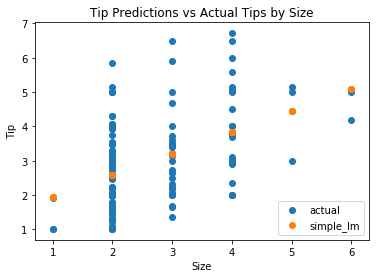

In [19]:
plt.scatter(X_train, y_train, label='actual')
plt.scatter(X_train, predictions.simple_lm, label='simple_lm')

plt.title('Tip Predictions vs Actual Tips by Size')
plt.xlabel('Size')
plt.ylabel('Tip')
plt.legend(loc='lower right')
plt.show()

In [20]:
# Create df with tip and predicted tip

example_tip = np.arange()
predicted_example_tip = lm.predict()

TypeError: arange() missing required argument 'start' (pos 1)

## Multiple Regression

- This would be more interesting if I had more X variables before feature selection...

In [21]:
import sklearn.feature_selection

In [22]:
X = train[['size', 'total_bill']]
y = train['tip']

lm = LinearRegression()

k = 2

rfe = sklearn.feature_selection.RFE(lm, k)

In [23]:
rfe.fit(X, y)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=2, step=1, verbose=0)

In [24]:
print('selected top feature', X.columns[rfe.support_])

selected top feature Index(['size', 'total_bill'], dtype='object')


In [25]:
X_rfe = rfe.transform(X)

In [26]:
lm.fit(X_rfe, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
# Is my model more accurate

predictions['multiple_rfe'] = lm.predict(X_rfe)
predictions.head()

,actual,simple_lm,multiple_rfe
149,1.73,2.580190,2.056616
214,2.50,2.580190,2.332884
179,4.00,2.580190,2.042367
42,2.54,2.580190,2.664565
120,2.92,3.832231,3.585589


## Evaluate Sklearn LinearRegression Model Performance

In [ ]:
mse_lm1 = mean_squared_error(y_train, yhat)
print(f"Linear Model Evaluation Metrics:\nMean Squared Error: {mse_lm1:.3}") 
print()
r2_lm1 = r2_score(y_train, yhat)
print(f"r2_score: {r2_lm1:.2%}")
print()
print(f"This means that {r2_lm1:.2%} of the variance in the value of tips can be explained by the size of the party.")

In [ ]:
# This is another way to return the r-squared of our model

print('r2 = ', lm1.score(X_train, y_train))  # feeding in X_train, y_train
print('r2 = ', r2_score(y_train, yhat))      # feeding in y_train, yhat

## Let's Check out the Residuals

- A residual is a measure of how far away a point is vertically from the regression line. It is the error between a predicted value and the observed actual value.


- A typical Residual Plot has the residual values on the Y-axis and the independent variable on the x_axis. 


- The most important assumption of a linear regression model is that the errors are independent and normally distributed. So, what does a good Residual Plot look like?

    - It has a high density of points close to the origin and low density of points away from the origin.
    
    - It is symmetric about the origin.
    
    - If we project all of the residuals onto the y_axis, we should have a normally distributed curve.
    
    - We should not see any patterns in the residuals as we move along the x-axis.
    

- If we do not see the characteristics above, it means we have not completely captured the predictive information of the data in our model.


- Finding patterns in our residuals may mean that there is a non-linear relationship.

## Create the OLS Model and Print out Evaluation Summary

- OLS stands for Ordinary Least Squares, and the method 'Least Squares' means that we're trying to fit a regression line that would minimize the square of distance from the regression line.


- The r-squared value returned here is .205 which means that about 21% of the variance in tip values is explained by the size of the parties at the restaurant.


- Our r-squared value here is pretty right on with our Linear Regression model above.

In [ ]:
# ols_model = ols('y ~ x', data=df).fit()
# ols_yhat = ols_model.predict(x)

tips_model = ols('tip ~ size', data=train).fit()
tips_yhat = tips_model.predict(X_train)

tips_model.summary()

## Polynomial Features

- Be careful about the curse of dimensionality. The number of combinations rises rapidly as you add features! It's not linear growth...

| Term  |  Dtype  |
|------:|--------:|